In [1]:
import pandas as pd
import requests
from pathlib import Path
import json
import datetime

import numpy as np

import load_data as ld
import os

import twitter_lib as tl
import wsj_lib as wsj
import matplotlib.pyplot as plt
# Import ClusterCentroids from imblearn
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [2]:
coin = 'ethereum'
prefix='eth'
coin_ticker='ETH-USD'
num_of_periods = 1000 # 1000 days

start="2019-04-01T00:00:00Z"
end ="2022-01-30T00:00:00Z"
#default bin size of 24H, but we will provide ...just..
bin_size='24H'

In [3]:
wsj_sentiment=wsj.get_sentiments_from_wsj()

In [4]:
wsj_sentiment.head()

,scores,sentiment
Date,,
1/1/00,0.00000,neutral
1/1/01,-0.09545,neg
1/1/02,-0.14800,neg
1/1/03,0.14985,pos
1/1/04,0.00000,neutral


In [5]:
wsj_sentiment=wsj_sentiment.reset_index()

In [6]:
wsj_sentiment['Date']=pd.to_datetime(wsj_sentiment['Date'])

In [7]:
wsj_sentiment=wsj_sentiment.set_index('Date')

In [8]:
wsj_sentiment=wsj_sentiment.groupby(by='Date').mean()

In [9]:
wsj_sentiment

,scores
Date,
1998-01-07,-0.273200
1998-02-12,0.000000
1998-03-26,0.000000
1998-05-03,0.000000
1998-05-04,0.000000
...,...
2021-06-26,0.152933
2021-06-27,0.000000
2021-06-28,-0.273200


In [10]:
sentiment_df = wsj_sentiment.copy()

In [11]:
sentiment_df

,scores
Date,
1998-01-07,-0.273200
1998-02-12,0.000000
1998-03-26,0.000000
1998-05-03,0.000000
1998-05-04,0.000000
...,...
2021-06-26,0.152933
2021-06-27,0.000000
2021-06-28,-0.273200


In [12]:
df_coin= ld.load_from_yahoo([coin_ticker], start,end)

In [13]:
'''short_window=10
long_window = 100
df_coins=pd.DataFrame(df_coin[coin_ticker]['close'])
df_coins['sig']=0.0
df_coins['SMA_short'] = df_coins['close'].rolling(window=short_window).mean()
df_coins['SMA_long'] = df_coins['close'].rolling(window=long_window).mean()
df_coins['sig'][short_window:] = np.where(
    df_coins['SMA_short'][short_window:] > df_coins['SMA_long'][short_window:], 1.0, 0.0
    )
df_coins['signal'] = df_coins['sig'].diff()
    
df_coins[df_coins['signal']==-1]
'''

"short_window=10\nlong_window = 100\ndf_coins=pd.DataFrame(df_coin[coin_ticker]['close'])\ndf_coins['sig']=0.0\ndf_coins['SMA_short'] = df_coins['close'].rolling(window=short_window).mean()\ndf_coins['SMA_long'] = df_coins['close'].rolling(window=long_window).mean()\ndf_coins['sig'][short_window:] = np.where(\n    df_coins['SMA_short'][short_window:] > df_coins['SMA_long'][short_window:], 1.0, 0.0\n    )\ndf_coins['signal'] = df_coins['sig'].diff()\n    \ndf_coins[df_coins['signal']==-1]\n"

In [14]:
df_coin

ETH-USD                                                      \
                   high          low         open        close       volume   
Date                                                                          
2019-03-31   142.189209   140.697372   142.139221   141.514099   4249050197   
2019-04-01   142.733994   140.737564   141.465485   141.830322   4611999536   
2019-04-02   165.226822   141.636459   141.839523   163.961746   9826645698   
2019-04-03   178.322052   157.322144   164.008636   161.458801  10622456246   
2019-04-04   164.929214   155.241104   161.431763   158.052536   7953123529   
...                 ...          ...          ...          ...          ...   
2022-01-26  2705.784180  2417.683105  2455.579102  2468.030273  21229909340   
2022-01-27  2510.451660  2328.452148  2467.188477  2423.001221  16126522783   
2022-01-28  2548.778564  2367.833740  2421.646973  2547.092041  14666227351   
2022-01-29  2627.609375  2526.989746  2546.590576  2597.084717  11172062661   
2022-01-30  2631.408447  2550.460938  2598.564941  2603.466553   9501221177   

                         
              adj close  
Date                     
2019-03-31   141.514099  
2019-04-01   141.830322  
2019-04-02   163.961746  
2019-04-03   161.458801  
2019-04-04   158.052536  
...                 ...  
2022-01-26  2468.030273  
2022-01-27  2423.001221  
2022-01-28  2547.092041  
2022-01-29  2597.084717  
2022-01-30  2603.466553  

[1037 rows x 6 columns]

In [15]:
df_coin.index

DatetimeIndex(['2019-03-31', '2019-04-01', '2019-04-02', '2019-04-03',
               '2019-04-04', '2019-04-05', '2019-04-06', '2019-04-07',
               '2019-04-08', '2019-04-09',
               ...
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30'],
              dtype='datetime64[ns]', name='Date', length=1037, freq=None)

In [16]:
joined_df = sentiment_df.join(df_coin[coin_ticker]['close'])

In [17]:
joined_df['daily_ret']=joined_df['close'].pct_change().shift()

In [18]:
short_window = 6
long_window = 100

In [19]:
joined_df['SENTIMENT_short_wsj']=joined_df['scores'].rolling(window=short_window).mean()
joined_df['SENTIMENT_long_wsj']=joined_df['scores'].rolling(window=long_window).mean()

In [20]:
X=joined_df[['SENTIMENT_short_wsj', 'SENTIMENT_long_wsj']].copy()

In [21]:
joined_df['signal'] = 0.0
joined_df.loc[(joined_df['daily_ret'] >= 0), 'signal'] = 1
joined_df.loc[(joined_df['daily_ret'] < 0), 'signal'] = -1


In [22]:
joined_df

,scores,close,daily_ret,SENTIMENT_short_wsj,SENTIMENT_long_wsj,signal
Date,,,,,,
1998-01-07,-0.273200,NaN,NaN,NaN,NaN,0.0
1998-02-12,0.000000,NaN,NaN,NaN,NaN,0.0
1998-03-26,0.000000,NaN,NaN,NaN,NaN,0.0
1998-05-03,0.000000,NaN,NaN,NaN,NaN,0.0
1998-05-04,0.000000,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...
2021-06-26,0.152933,1829.239258,-0.088128,0.053076,0.019236,-1.0
2021-06-27,0.000000,1978.894653,0.008836,-0.023390,0.017457,1.0
2021-06-28,-0.273200,2079.657471,0.081813,-0.083586,0.013043,1.0


In [23]:
joined_df=joined_df.dropna()

In [24]:
#joined_df['diff_signal'] = joined_df['signal'].diff()

In [25]:
joined_df=joined_df.dropna()

In [26]:
X=joined_df[['SENTIMENT_short_wsj', 'SENTIMENT_long_wsj']].copy()
y = joined_df['signal'].copy()

In [27]:
X=pd.DataFrame(joined_df['scores'])

In [28]:
X

,scores
Date,
2019-04-02,0.000000
2019-04-03,0.042100
2019-04-04,0.120400
2019-04-05,0.000000
2019-04-06,0.273400
...,...
2021-06-26,0.152933
2021-06-27,0.000000
2021-06-28,-0.273200


In [29]:
y

Date
2019-04-02    1.0
2019-04-03    1.0
2019-04-04   -1.0
2019-04-05   -1.0
2019-04-06    1.0
             ... 
2021-06-26   -1.0
2021-06-27    1.0
2021-06-28    1.0
2021-06-29    1.0
2021-06-30    1.0
Name: signal, Length: 797, dtype: float64

In [30]:
X.to_csv('X.csv')
y.to_csv('y.csv')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train

,scores
Date,
2019-05-21,0.000000
2021-05-06,0.535600
2020-07-05,0.156000
2019-11-20,-0.127267
2019-09-28,-0.495650
...,...
2021-02-24,-0.472567
2019-10-13,0.000000
2019-05-19,0.184100


In [32]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [33]:
X_train_scaled.shape

(597, 1)

In [34]:


# Instantiate a ClusterCentroids instance
cc_sampler = ClusterCentroids(random_state=1)
# Fit the training data to the cluster centroids model
X_resampled, y_resampled = cc_sampler.fit_resample(X_train_scaled, y_train)

/Users/ashokpandey/opt/anaconda3/envs/dev/lib/python3.7/site-packages/imblearn/under_sampling/_prototype_generation/_cluster_centroids.py:172: ConvergenceWarning: Number of distinct clusters (226) found smaller than n_clusters (272). Possibly due to duplicate points in X.
  self.estimator_.fit(X[y == target_class])


In [35]:
# Count distinct values for the resampled target data
y_resampled.value_counts()

-1.0    272
 1.0    272
Name: signal, dtype: int64

In [36]:
lr = LogisticRegression()

In [37]:
lr.fit(X_resampled, y_resampled)
# Make predictions using the test data
y_pred = lr.predict(X_test_scaled)

In [38]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame()
    
predictions_df['Predicted'] = y_pred 
predictions_df.index=X_test.index
# Add the actual returns to the DataFrame
x = joined_df.loc[X_test.index[0]:]
predictions_df['Actual Returns'] = x['daily_ret']
# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']
predictions_df.dropna()
# Plot the actual returns versus the strategy returns
cum_ret=(1+predictions_df[['Strategy Returns', 'Actual Returns']]).cumprod()

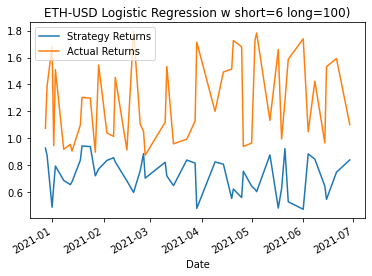

In [39]:
cum_ret.plot(title=coin_ticker+' Logistic Regression w short=6 long=100)')
plt.savefig(prefix+'_Log_reg_SMA_short6_long100.png')

In [40]:
# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

[[50 47]
 [56 47]]


In [41]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.47      0.52      0.49        97
         1.0       0.50      0.46      0.48       103

    accuracy                           0.48       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.49      0.48      0.48       200



In [42]:
#get the current news and data from augmento
#run the data prep to get the X_test_scaled data so it can be tested


In [43]:
#pred_cumprod = ml.get_Strategy_and_Actual_returns(X_test.index, y_pred, signals_test_df )

In [44]:
# Instantiate a linear SVM model
from sklearn.svm import SVC
svm = SVC(kernel='linear')
# Fit the data
svm.fit(X_resampled, y_resampled)
# Make predictions using the test data
y_pred = svm.predict(X_test_scaled)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.44      0.58      0.50        97
         1.0       0.45      0.32      0.37       103

    accuracy                           0.45       200
   macro avg       0.45      0.45      0.44       200
weighted avg       0.45      0.45      0.44       200



In [45]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame()
    
predictions_df['Predicted'] = y_pred 
predictions_df.index=X_test.index
# Add the actual returns to the DataFrame
x = joined_df.loc[X_test.index[0]:]
predictions_df['Actual Returns'] = x['daily_ret']
# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']
predictions_df.dropna()
# Plot the actual returns versus the strategy returns
cum_ret=(1+predictions_df[['Strategy Returns', 'Actual Returns']]).cumprod()

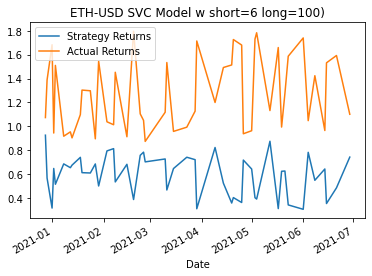

In [46]:
cum_ret.plot(title=coin_ticker+ ' SVC Model w short=6 long=100)')
plt.savefig(prefix+ '_SVC_SMA_short6_long100.png')